# Validation and Convergence Test DCWM
## Second order binding task
### Controller dim=512
### Random Network Parameter=1/3
### Interface Vector Dim= 350
# For clarity we seperate this section from code of task with test
### This file's parameters are dependent on each others (all_n, epochsnum, and n) and set by hand, at the first step please run code by default paramters


In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from model import DCWM
from trainer import trainer

import pickle
import dill

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Generate or Loading training data

In [2]:
cols = 8
remembered = 2 
n=2000 # all posible sequences is (2^8)^rem(2)= 65,536

### X

In [3]:
x=np.random.randint(0,2,(1,1,cols))
for i in range(n):
    temp=np.random.randint(0,2,(1,1,cols))
    x=np.append(x,temp,axis=0)

In [4]:
#x

## Y

In [5]:
temp=np.concatenate((x[0],x[-2]),axis=1)
y=temp.reshape(1,1,cols*remembered)

for i in range(n):
    temp=np.concatenate((x[i+1],x[i-1]),axis=1)
    y=np.append(y,temp.reshape(1,1,cols*remembered),axis=0)


In [6]:
#y

In [7]:
#saving for first run
#outline it for loading previous model
#dill.dump(x, file = open("x.pickle", "wb"))
#dill.dump(y, file = open("y.pickle", "wb"))

In [8]:
#loading for next runs
x=dill.load(open("x.pickle", "rb"))
y=dill.load(open("y.pickle", "rb"))

### see train data format

In [9]:
np.shape(x)

(2001, 1, 8)

In [10]:
np.shape(y)

(2001, 1, 16)

## Initialize and train model

Initialize or loading:

In [11]:
test_num_val=99 #number of random test data set -1. 

#create the test
test_num=test_num_val
#X 
x_test=np.random.randint(0,2,(1,1,cols))
for i2 in range(test_num):
    temp=np.random.randint(0,2,(1,1,cols))
    x_test=np.append(x_test,temp,axis=0)
    
#Y 
temp=np.concatenate((x_test[0],x[-2]),axis=1)
y_test=temp.reshape(1,1,cols*remembered)
temp=np.concatenate((x_test[1],x[-1]),axis=1)
y_test=np.append(y_test,temp.reshape(1,1,cols*remembered),axis=0)
for i3 in range(test_num-1):
    temp=np.concatenate((x_test[i3+2],x_test[i3]),axis=1)
    y_test=np.append(y_test,temp.reshape(1,1,cols*remembered),axis=0)


In [12]:
#saving for first run
#outline it for loading previous model
#dill.dump(x_test, file = open("x_test.pickle", "wb"))
#dill.dump(y_test, file = open("y_test.pickle", "wb"))

In [13]:
#loading for next runs
x_test=dill.load(open("x_test.pickle", "rb"))
y_test=dill.load(open("y_test.pickle", "rb"))

In [14]:
y_test_show=np.zeros((cols*remembered,test_num+1))
test_num=test_num+1
for i4 in range(cols*remembered):
    for j4 in range(test_num):
        y_test_show[i4,j4]=y_test[j4,0,i4]


all_n=25# =n1 + n2 + n3 (if epochsnum=1 it means after each epochs)
# sum of number of all epochs so we save validation test's results after each epochs in it.
# size of array of validation tests.
# this parameter set by hand and if you want different number of run, you must change it.

ERROR_IN_ITTERATE=np.zeros(all_n)

In [15]:
interface_vactor_dim=350 #defult 35

In [16]:
dcwm = DCWM(input_dim=cols,output_dim=remembered*cols,controller_dime=512,interface_dim=interface_vactor_dim,netsize=1000,degree=20)
history=[]

In [17]:
#If you want load previous model use online all of them
dcwm= dill.load(open("trained_dcwm.pickle", "rb"))
history= dill.load(open("history.pickle", "rb"))
ERROR_IN_ITTERATE= dill.load(open("error_in_itterate.pickle", "rb"))

Train:

In [18]:
#n*epochs=all_number_of_epochs_with_this_training_rate
n=0 #set 5 for default to train the model or 0 to see the results from loading the model
lastnum=0 #last number of last run_shows
epochsnum=1

In [19]:
#I use loop because I dont have powerfull device to run whole epochs at ones and I need save and check point in each round
for i in range(n):
    h=trainer(
        model=dcwm,
        loss_fn=tf.keras.losses.mse,
        X_train=x,
        y_train=y,
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
        epochs=epochsnum,
        batch_size=1,
        verbose=True)
    print((i+1)*epochsnum+lastnum)
    history=np.append(history,h)
        
    #Y predict #5, 6
    y_temp , v = dcwm(x_test[0]) 
    y_pred=y_temp.numpy().reshape(1,remembered*cols)
    i5=1
    while i5 < test_num:
        y_pred_temp , v = dcwm(x_test[i5]) 
        y_pred=np.append(y_pred,y_pred_temp.numpy().reshape(1,remembered*cols),0)
        i5=i5+1
    y_pred=y_pred.T
    
    y_decide=np.zeros(y_pred.shape)
    for i6 in range(2*cols):
        for j6 in range(test_num):
            if y_pred[i6,j6]>(1/2) : # thereshold 0.5
               y_decide[i6,j6]=1
    
    #error in test #7
    for i7 in range(2*cols):
        for j7 in range(test_num):
            if (y_decide[i7,j7].astype(int)!=y_test_show[i7,j7]):
                ERROR_IN_ITTERATE[i+lastnum]=ERROR_IN_ITTERATE[i+lastnum]+1
    #save model
    dill.dump(dcwm, file = open("trained_dcwm.pickle", "wb"))
    dill.dump(history, file = open("history.pickle", "wb"))
    dill.dump(ERROR_IN_ITTERATE,file = open("error_in_itterate.pickle", "wb"))


In [20]:
#n*epochs=all_number_of_epochs_with_this_training_rate
n=0 #set 10 for default to trian the model or 0 to see the results from loading the model
lastnum=5 #last number of last run_shows
epochsnum=1

In [21]:
#I use loop because I dont have powerfull device to run whole epochs at ones and I need save and check point in each round
for i in range(n):
    h=trainer(
        model=dcwm,
        loss_fn=tf.keras.losses.mse,
        X_train=x,
        y_train=y,
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
        epochs=epochsnum,
        batch_size=1,
        verbose=True)
    print((i+1)*epochsnum+lastnum)
    history=np.append(history,h)
    
    #Y predict #5, 6
    y_temp , v = dcwm(x_test[0]) 
    y_pred=y_temp.numpy().reshape(1,remembered*cols)
    i5=1
    while i5 < test_num:
        y_pred_temp , v = dcwm(x_test[i5]) 
        y_pred=np.append(y_pred,y_pred_temp.numpy().reshape(1,remembered*cols),0)
        i5=i5+1
    y_pred=y_pred.T
    
    y_decide=np.zeros(y_pred.shape)
    for i6 in range(2*cols):
        for j6 in range(test_num):
            if y_pred[i6,j6]>(1/2) : # thereshold 0.5
               y_decide[i6,j6]=1
    
    #error in test #7
    for i7 in range(2*cols):
        for j7 in range(test_num):
            if (y_decide[i7,j7].astype(int)!=y_test_show[i7,j7]):
                ERROR_IN_ITTERATE[i+lastnum]=ERROR_IN_ITTERATE[i+lastnum]+1
    #save model
    dill.dump(dcwm, file = open("trained_dcwm.pickle", "wb"))
    dill.dump(history, file = open("history.pickle", "wb"))
    dill.dump(ERROR_IN_ITTERATE,file = open("error_in_itterate.pickle", "wb"))


### we use 1e-6 so you can see convergence better (but it's not necessary)

In [22]:
#n*epochs=all_number_of_epochs_with_this_training_rate
n=0 #set 10 for default to train the model or 0 to see the results from loading the model
lastnum=15 #last number of last run_shows
epochsnum=1

In [23]:
#I use loop because I dont have powerfull device to run whole epochs at ones and I need save and check point in each round
for i in range(n):
    h=trainer(
        model=dcwm,
        loss_fn=tf.keras.losses.mse,
        X_train=x,
        y_train=y,
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-6),
        epochs=epochsnum,
        batch_size=1,
        verbose=True)
    print((i+1)*epochsnum+lastnum)
    history=np.append(history,h)
    
    #Y predict #5, 6
    y_temp , v = dcwm(x_test[0]) 
    y_pred=y_temp.numpy().reshape(1,remembered*cols)
    i5=1
    while i5 < test_num:
        y_pred_temp , v = dcwm(x_test[i5]) 
        y_pred=np.append(y_pred,y_pred_temp.numpy().reshape(1,remembered*cols),0)
        i5=i5+1
    y_pred=y_pred.T
    
    y_decide=np.zeros(y_pred.shape)
    for i6 in range(2*cols):
        for j6 in range(test_num):
            if y_pred[i6,j6]>(1/2) : # thereshold 0.5
               y_decide[i6,j6]=1
    
    #error in test #7
    for i7 in range(2*cols):
        for j7 in range(test_num):
            if (y_decide[i7,j7].astype(int)!=y_test_show[i7,j7]):
                ERROR_IN_ITTERATE[i+lastnum]=ERROR_IN_ITTERATE[i+lastnum]+1
    #save model
    dill.dump(dcwm, file = open("trained_dcwm.pickle", "wb"))
    dill.dump(history, file = open("history.pickle", "wb"))
    dill.dump(ERROR_IN_ITTERATE,file = open("error_in_itterate.pickle", "wb"))


## Loss

In [24]:
np.size(history)
xyz=np.zeros(np.size(history))
for i in range(np.size(history)):
    xyz[i]=i

<IPython.core.display.Javascript object>


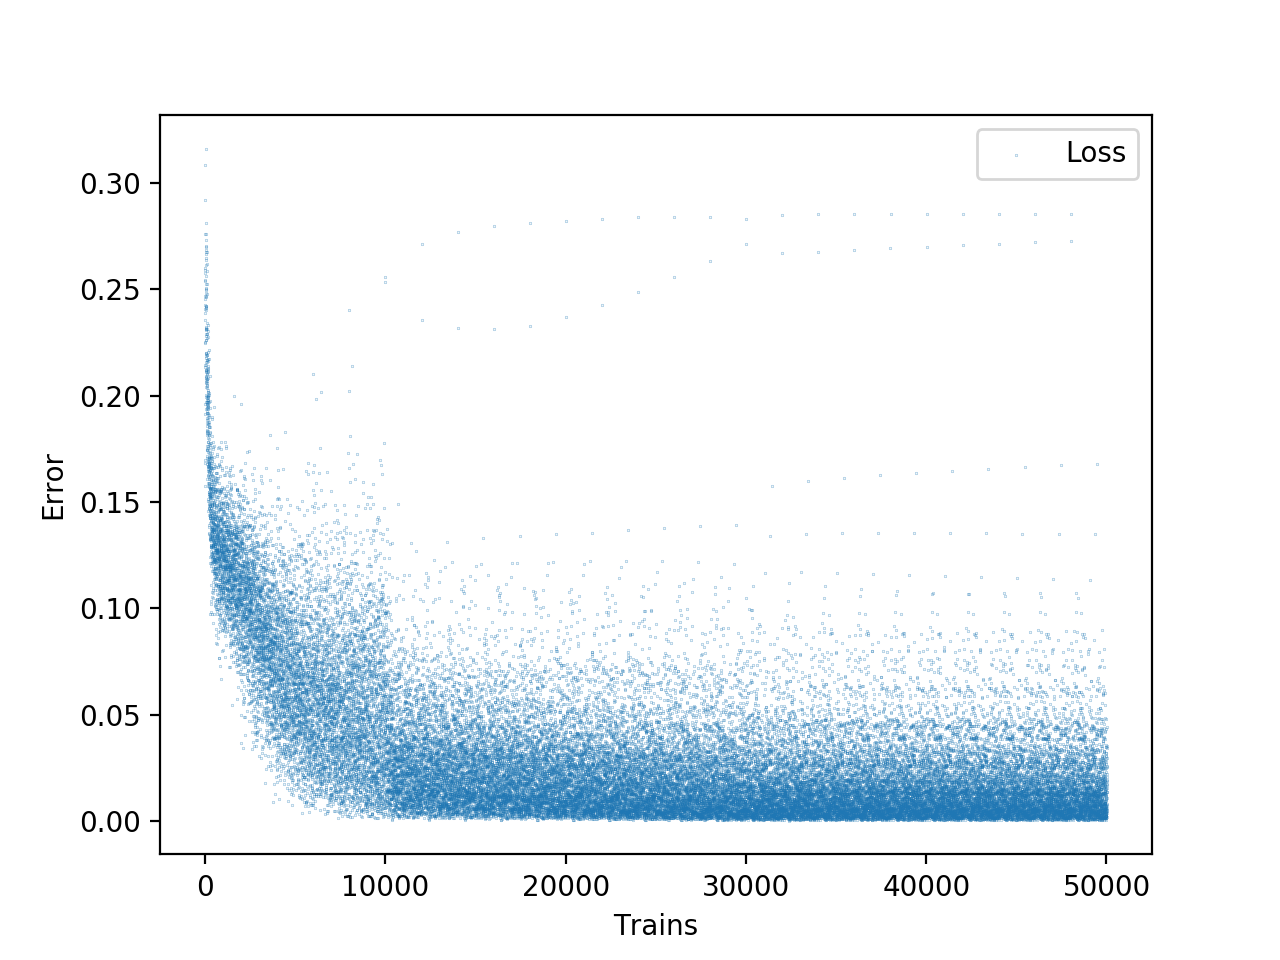

In [25]:
#history
%matplotlib notebook
#fig = plt.figure(figsize=(6,5), dpi=600) #for HQ Fig
plt.scatter(xyz, history,0.01 ,label='Loss')
plt.xlabel('Trains')
plt.ylabel('Error')
plt.legend()
plt.show()
#fig.savefig('afterConv.png')

<IPython.core.display.Javascript object>


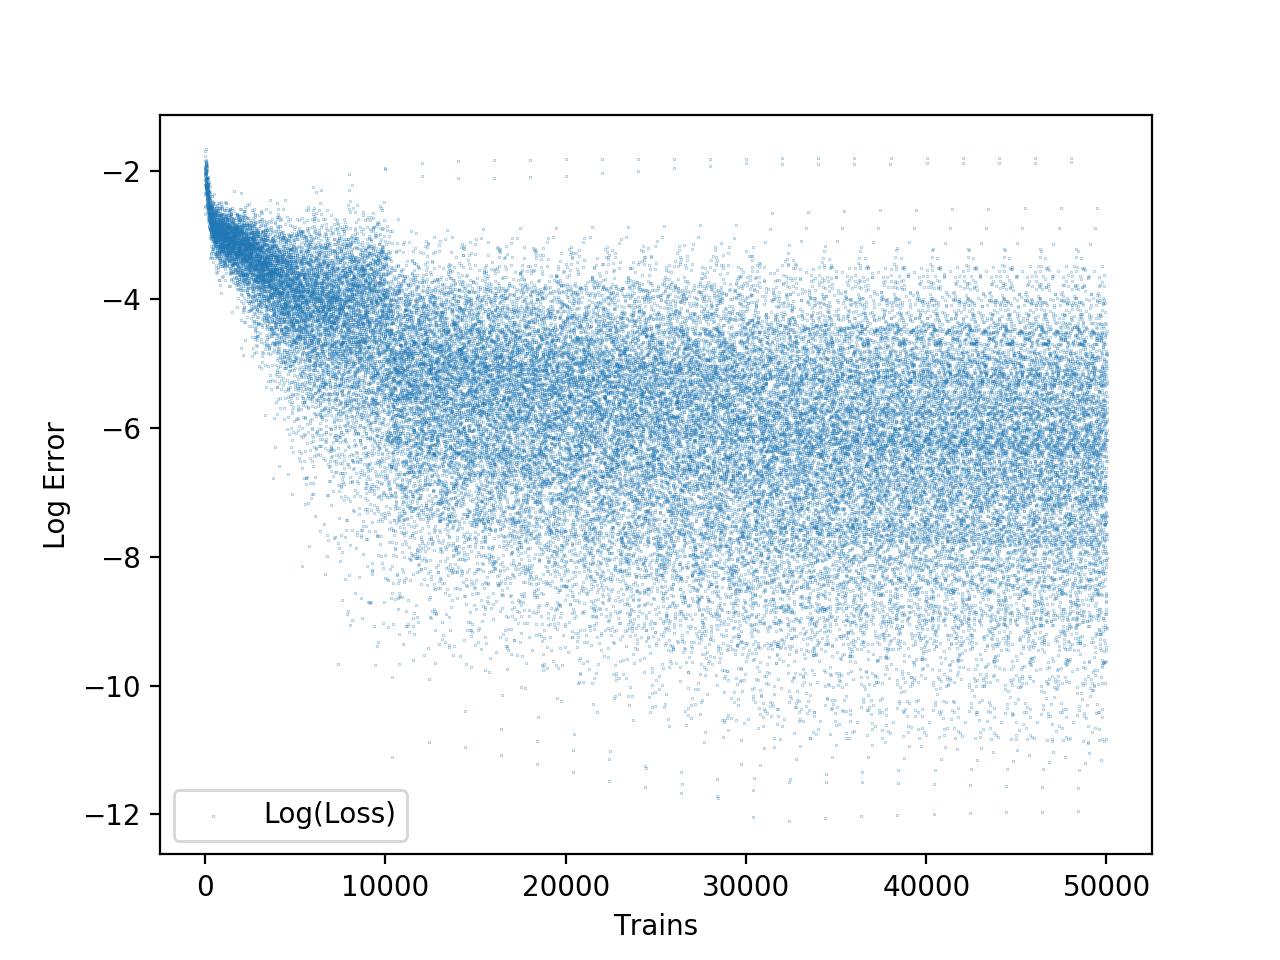

In [26]:
%matplotlib notebook
#fig = plt.figure(figsize=(6,5), dpi=600) #fro HQ Fig
plt.scatter(xyz, np.log2(history),0.01 ,label='Log(Loss)')
plt.xlabel('Trains')
plt.ylabel('Log Error')
plt.legend()
plt.show()
#fig.savefig('Logloss.png')

## Validation test

In [27]:
VALIDATION_TEST=1-(ERROR_IN_ITTERATE/(16*(test_num_val+1)))

<IPython.core.display.Javascript object>


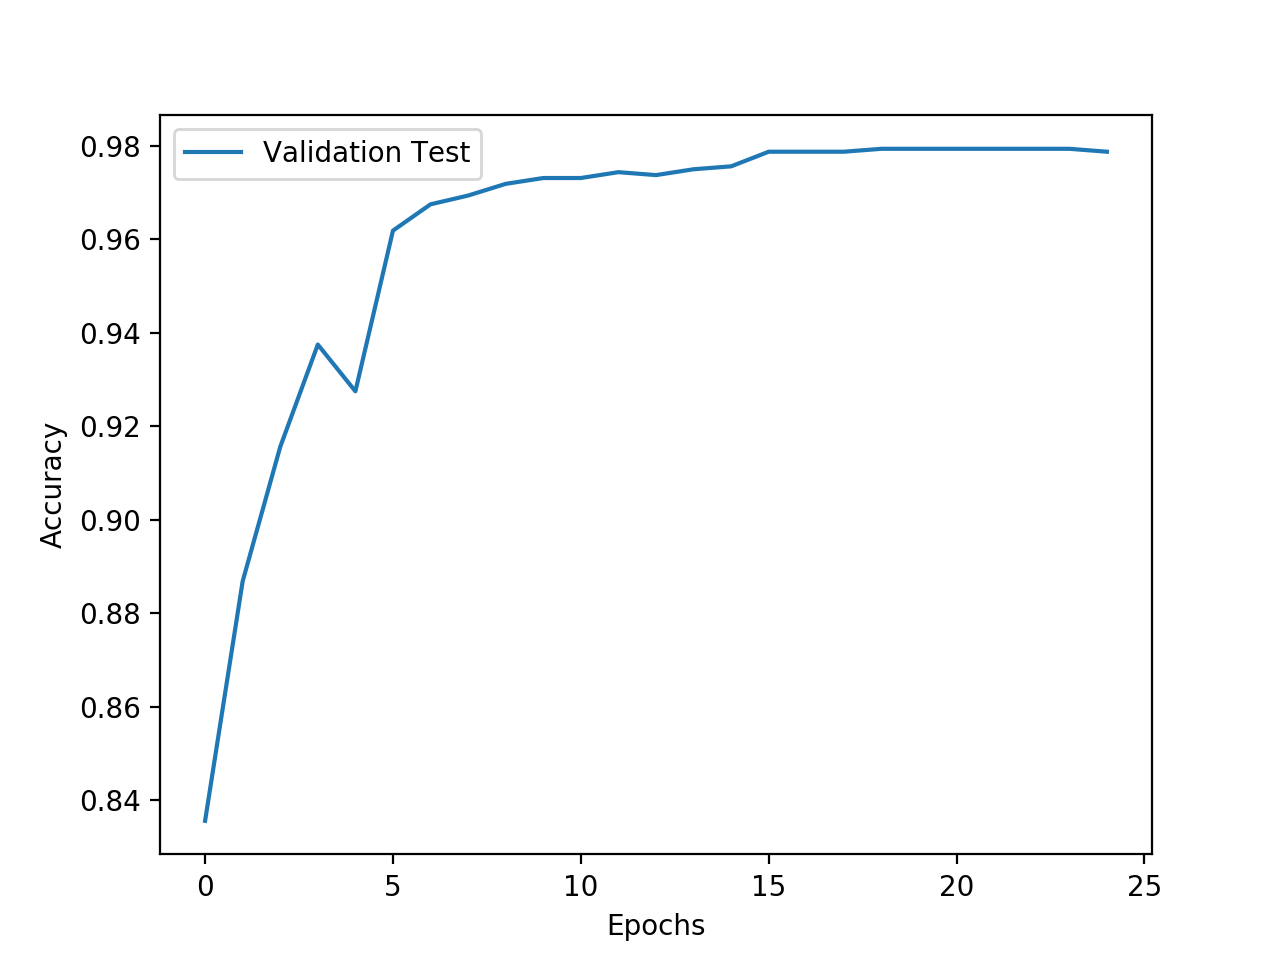

In [28]:
#validation in all_number/epochsnum
%matplotlib notebook
#fig = plt.figure(figsize=(6,5), dpi=600) #for HQ fig
plt.plot(VALIDATION_TEST, label='Validation Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#fig.savefig('VALIDATION.png')

## Analysis of loss

In [29]:
CoE=np.zeros(np.size(history)-200)
for i in range(np.size(history)-200):
    CoE[i]=np.sum(history[i:i+200])/200

<IPython.core.display.Javascript object>


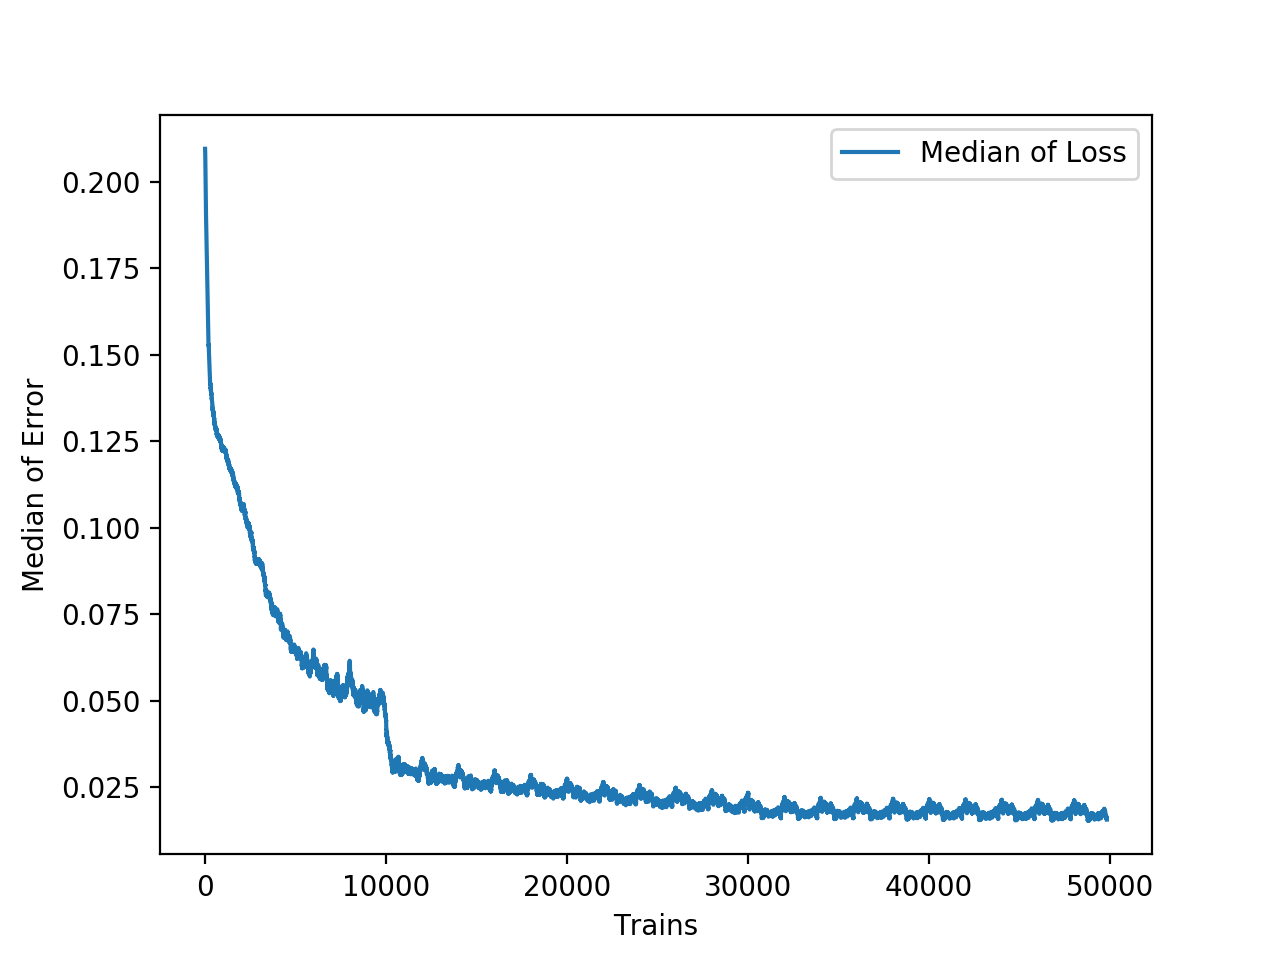

In [30]:
%matplotlib notebook
#fig=plt.figure(figsize=(6,5), dpi=600) #for HQ fig
plt.plot(CoE,label='Median of Loss')
plt.xlabel('Trains')
plt.ylabel('Median of Error')
plt.legend()
plt.show()
#fig.savefig('convergence of Medain of loss.png')

In [31]:
CoE2=np.zeros(np.size(history)-200)
for i in range(np.size(history)-200):
    CoE2[i]=np.sum(np.log2(history[i:i+200]))/200

<IPython.core.display.Javascript object>


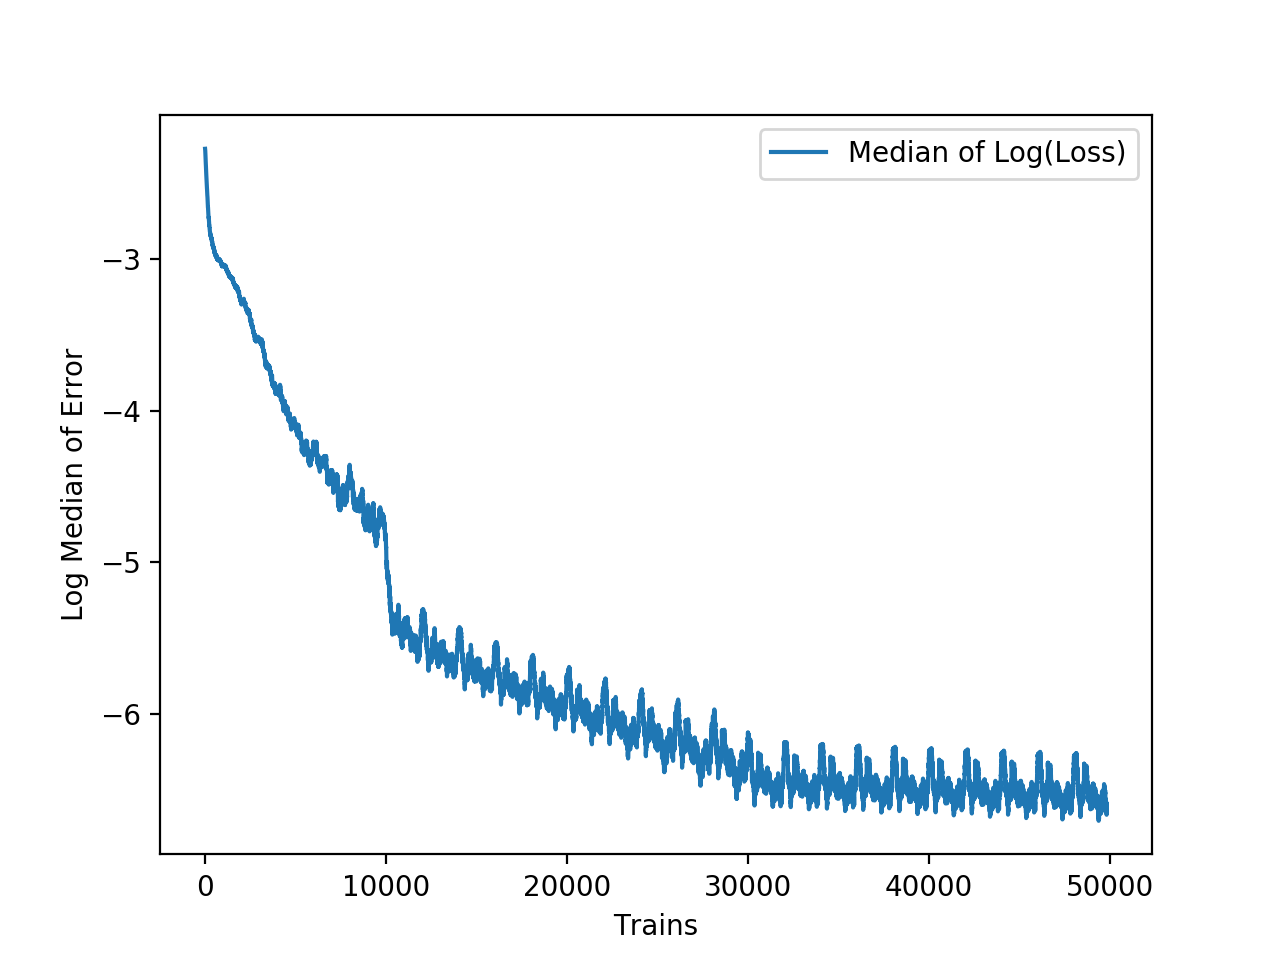

In [32]:
%matplotlib notebook
#fig=plt.figure(figsize=(6,5), dpi=600) #for HQ Fig
plt.plot(CoE2,label='Median of Log(Loss)')
plt.xlabel('Trains')
plt.ylabel('Log Median of Error')
plt.legend()
plt.show()
#fig.savefig('convergence of Log Medain.png')